# Experiment - 16 June 2017 

## Task 1 - Cohort extraction

In [117]:
%matplotlib inline
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

sns.set(color_codes=True)
sns.set(rc={"figure.figsize": (16, 8)}); 
np.random.seed(20170619)

In [4]:
wards = pd.read_excel("./Coll.centre key_v3.xlsx")
ICU_wards = wards[wards['ICU']==1.0]
General_wards = wards[wards['General Ward']==1.0]
exclude = wards[wards['To exclude']==1.0]
location = 'Coll.Centre'
targets = list(ICU_wards[location])
list(ICU_wards[location])

['NICU', 'PAED HDU', 'PICU']

In [ ]:
# Read Data
H1 = pd.read_excel("H1.xlsx")
A1 = pd.read_excel("A1.xlsx")

In [ ]:
H1.to_pickle("H1.pkl")
A1.to_pickle("A1.pkl")

In [5]:
H1 = pd.read_pickle("H1.pkl")
A1 = pd.read_pickle("A1.pkl")

In [6]:
# Make subjects from two sources unique in research ID 
A1['Research.ID'] = A1['Research.ID'].add(len(H1['Research.ID'].unique()))
dataframe = pd.concat([H1, A1])
#dataframe['Research.ID']

In [168]:
# Add age column 
dataframe['DoB'] = pd.to_datetime(dataframe['DoB'], format='%y%m%d')
dataframe['Collected'] = pd.to_datetime(dataframe['Collected'], format='%y%m%d')
dataframe['age'] = (dataframe['Collected'] - dataframe['DoB']).astype('<m8[Y]')
dataframe = dataframe.sort_values(['Research.ID', 'Collected'])
dataframe.loc[:, ['Research.ID', 'DoB', 'Collected', 'age', 'SODIUM']]

In [22]:
# Exclude the To exclude wards first
include_crit = [i and j for i, j in zip(dataframe['age'] < 18.0, dataframe[location].map(lambda x: 
                                                                               x not in list(exclude[location])))]

include_cohort = dataframe.loc[include_crit, :]
group = include_cohort.groupby(by=['Research.ID'])
#include_cohort.loc[:, [location, 'age']]
include_cohort['Research.ID'].unique().shape

(53839,)

Cohort selection:

   * subject older than 18
   * moved to PICU or NICU once 

In [32]:
def addcol(x, lab_values=['SODIUM']):
    cond1 = False
    
    for icu in targets:
        temp = bool(x[location].str.contains(icu).sum())
        cond1 = temp or cond1 
    
    cond2 = bool((x['age'] < 18).sum())
    
    x['included'] = (cond1 and cond2)
    
    if x[location].iloc[0] in targets:
        x['included'] = False
    
    # inlcuded column is whether the patient is included in ICU 
    
    select = x[location].isin(targets)
    a = select.sum()
    for i in lab_values:
        labmax = i + "_max"
        labmin = i + "_min"
        if a:
            movetime = x.loc[select, "Collected"].iloc[0]
            #print(x["Collected"] < movetime)
            #print(movetime)
            #print(movetime - pd.Timedelta("24 hours "))
            #print(movetime)
            condition = [i and j for i, j in zip(x['Collected'].map(lambda x: x >= movetime-pd.Timedelta("24 hours")), 
                                                 x['Collected'].map(lambda x: x < movetime))]
            #print(condition)
            _max = x.loc[condition, "SODIUM"].max()
            _min = x.loc[condition, "SODIUM"].min()
        else:
            _max = x["SODIUM"].max()
            _min = x["SODIUM"].min()
        x[labmax] = _max
        x[labmin] = _min
    
    return x

In [33]:
data = group.apply(addcol)

In [34]:
#print(group.get_group(969))
#print(group.get_group(969))
#print(data.loc[data['Research.ID'] == 969, ['Research.ID', location, 'included']])
#print(data.loc[data[location].isin(targets), :])

In [44]:
data.loc[:, ['Research.ID', 'age', location, 
                            'Collected', 'SODIUM', "SODIUM_max", 
                            "SODIUM_min", 'included']].dropna()['Research.ID'].unique().shape[0]

17629

In [43]:
data.loc[data['included'], ['Research.ID', 'age', location, 
                            'Collected', 'SODIUM', "SODIUM_max", 
                            "SODIUM_min", 'included']].dropna()['Research.ID'].unique().shape[0]

173

In [42]:
data.loc[~data['included'], ['Research.ID', 'age', location, 
                            'Collected', 'SODIUM', "SODIUM_max", 
                            "SODIUM_min", 'included']].dropna()['Research.ID'].unique().shape[0]

17456

In [45]:
data.to_pickle("./data_3.pkl")

In [52]:
data = pd.read_pickle("./data_3.pkl")

In [54]:
data.loc[data['included'], ['Research.ID', 'Collected', location, 'SODIUM', 
                            'SODIUM_max', 'SODIUM_min', 'included']].dropna()['Research.ID'].unique().shape[0]

173

## Task 2: Distribution and patient in ICU ratio plot 

Use lab value = "SODIUM" as an example here. 

* Plot distribution histogram of lab value 
* In each bar of the histogram, plot the ratio of patients in ICU with lab values in this range ( ICU subjects / total subjects with in this value range). Note: ICU ratio is only plotted when number of patients > 10 in case of outliers

In [55]:
lab_value = ["SODIUM"]
lab_minmax = []
for i in lab_value:
    lab_minmax.extend([i+"_min", i+"_max"])
print(lab_minmax)
#data.loc[data['Research.ID']==80, ['Research.ID', "SODIUM", 'SODIUM_max', 'SODIUM_min', location, 'age', 'included']]

['SODIUM_min', 'SODIUM_max']


### Min and Max plot seperately 

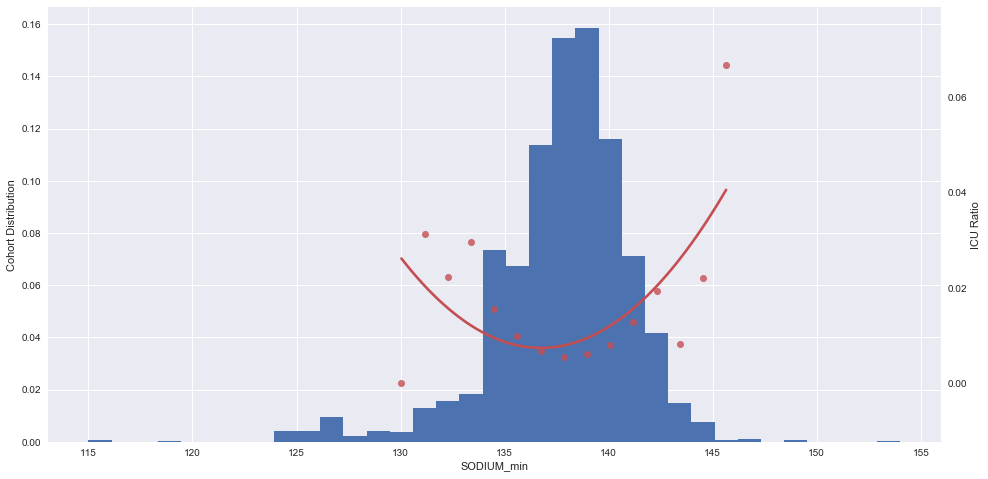

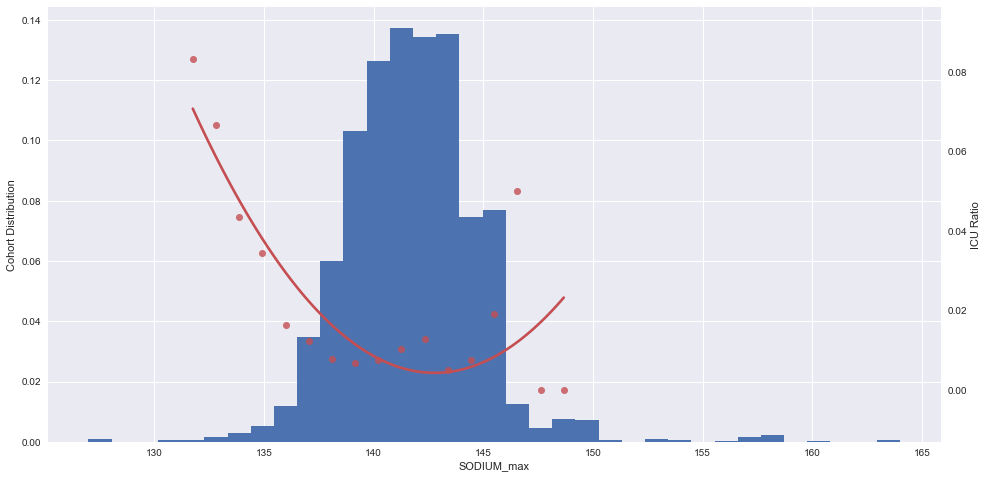

In [139]:
tenth, nintieth = np.percentile(data[lab_value].dropna(), [10, 90])

for lab in lab_minmax:
    fig, ax = plt.subplots()
    counts, bins, patches = ax.hist(data[lab].dropna(), bins=35, normed=True)
    ax.set_xbound(lower=tenth, upper=nintieth)
    ax.set_xlabel(lab)
    ax.set_ylabel("Cohort Distribution")
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    testar = []
    x = []
    y = []
    for i, reading in enumerate(bins[:-1]):
        criterion = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x >= bins[i] and x <= bins[i+1]))]
        subjects = data.loc[criterion, 'Research.ID'].unique()
        groups = data[data['Research.ID'].isin(subjects)].groupby('Research.ID')

        if len(subjects) > 10:
            value_count = float(groups.included.agg('max').sum()) / float(len(subjects))
            x.append((bins[i] + bins[i+1]) / 2.0)
            y.append(value_count)

    ax2 = ax.twinx()
    #print(x)
    #print(y)
    #ax2.scatter(x=x, y=y, c='r')
    ax2.grid(False)
    x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
    ax2 = sns.regplot(x=x, y=y,
                      scatter_kws={"s": 50},
                      color='r',
                      order=2, ci=None, truncate=True)
    ax2.set_ylabel("ICU Ratio")

## Task 3: Min/Max probability plot

for lab value i in 5 percentile to 95 percentile: 
$$
    P(y=1|x=i) = \frac{P(x=i|y=1) \cdot P(y=1)}{P(x=i)}
$$

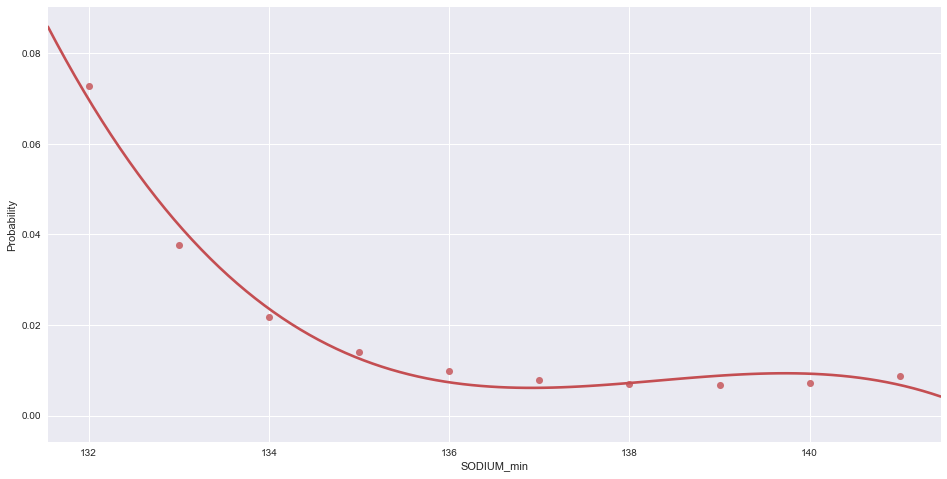

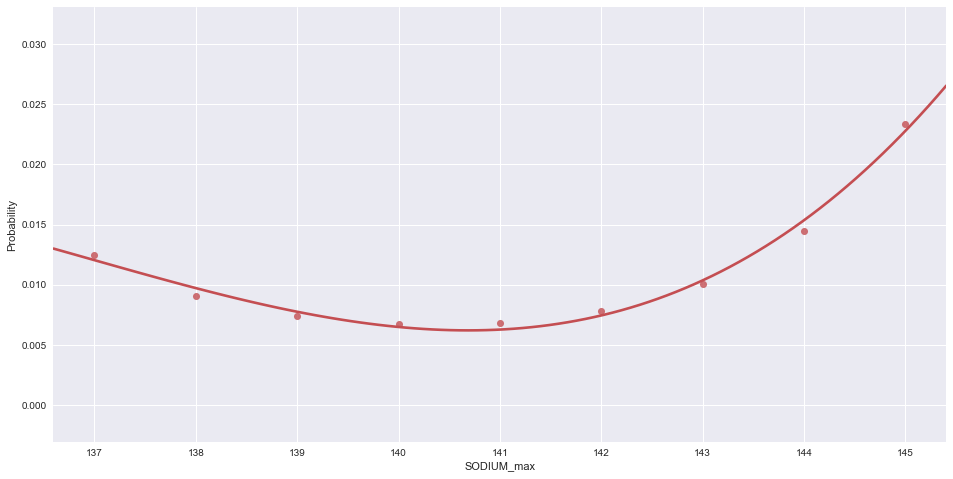

In [167]:
for lab in lab_minmax:
    tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    fig, ax = plt.subplots()
    
    
    _crit = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)))]
    _subjects = data.loc[_crit, 'Research.ID'].unique()
    _group = data[data['Research.ID'].isin(_subjects)].groupby('Research.ID')
    
    X = _group[lab].agg('max').as_matrix()
    y = _group['included'].agg('max').astype(int).as_matrix()
    
    bins = np.arange(tenth, nintieth)
    _x = []
    _y = []
    
    p_y_1 = y.sum() / y.shape[0]
    x_mean = np.mean(X)
    x_std = np.std(X)
    x_norm = scipy.stats.norm(x_mean, x_std)
    
    pos_crit = [i and j and z for i, j, z in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)), 
                                                 data['included'])]
    pos_subjects = data.loc[pos_crit, 'Research.ID'].unique()
    pos_group = data[data['Research.ID'].isin(pos_subjects)].groupby('Research.ID')
    X_pos = pos_group[lab].agg('max').as_matrix()
    y_pos = pos_group['included'].agg('max').astype(int).as_matrix()
    X_pos_mean = np.mean(X_pos)
    X_pos_std = np.std(X_pos)
    X_pos_norm = scipy.stats.norm(X_pos_mean, X_pos_std)
    
    for i in bins:
        _p = (X_pos_norm.pdf(i) * p_y_1) / x_norm.pdf(i)
        #if _p > 1:
        #print(X_pos_norm.pdf(i))
        #print(x_norm.pdf(i))
        #print(_p)
        _x.append(i)
        _y.append(_p)
    #ax.scatter(x=_x, y=_y, c='r')
    #print(_x)
    #print(_y)
    _x, _y = pd.Series(_x[:], name=""), pd.Series(_y[:], name="")
    ax = sns.regplot(x=_x, y=_y,
                      scatter_kws={"s": 50},
                      color='r',
                      order=3, ci=None, truncate=False)
    #ax.set_xbound(lower=tenth, upper=nintieth)
    ax.set_xlabel(lab)
    ax.set_ylabel("Probability")

## Task 4: Cumulative frequency plot

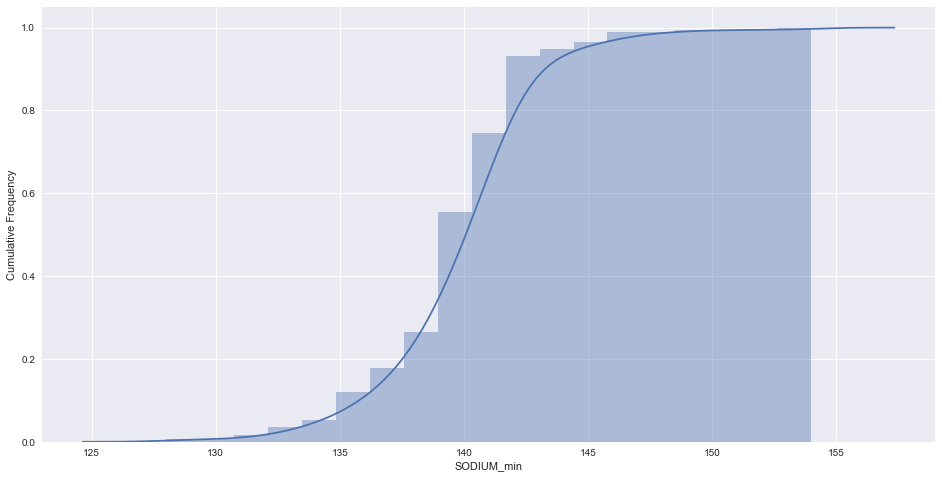

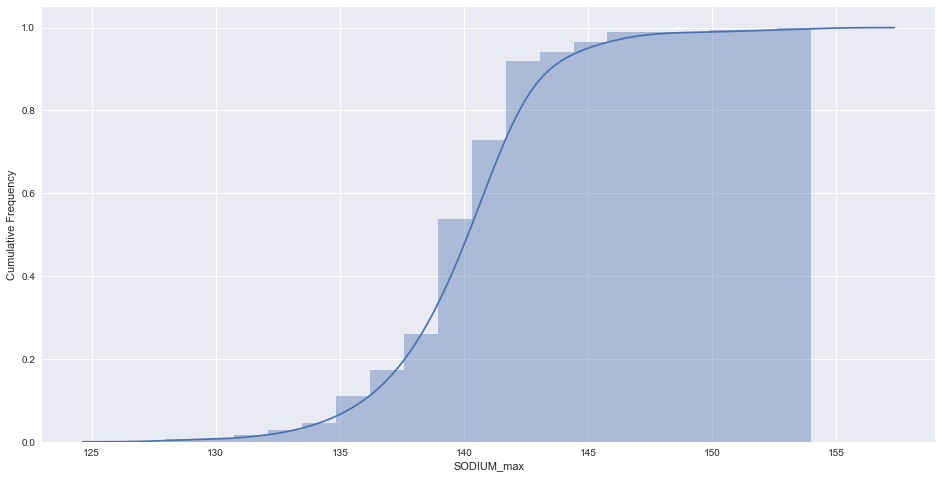

In [115]:
for lab in lab_minmax:
    fig, ax = plt.subplots()
    tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    
    crit_x = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x)))]
    subjects = data.loc[crit_x, 'Research.ID'].unique()
    x = []
    y = []
    for i in subjects:
        temp = np.max(data.loc[data['Research.ID']==i, lab])
        x.append(temp)
        
        temp_y = np.max(data.loc[data['Research.ID']==i, 'included'])
        y.append(temp_y)
    #print(x[:100])
    #print(y[:100])

    sns.distplot(x,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
    ax.set_xlabel(lab)
    ax.set_ylabel("Cumulative Frequency")

## (_* Removed *_) Task 3: Min / Max odds ratio plot 

Plot ICU odds ratio

Cohort (age < 18) for value range x: (when x < 140)

|                      | Outcomes: Converted to ICU | Not converted to ICU |   |   |
|----------------------|-----------------------------|------------------------------|---|---|
|  Exposures: Max/Min value <= x    | a                           | b                            |   |   |
| Max/Min value > x | c                           | d                            |   |   |

when x >= 140 

|                      | Outcomes: Converted to ICU | Not converted to ICU |   |   |
|----------------------|-----------------------------|------------------------------|---|---|
|  Exposures: Max/Min value >= x    | a                           | b                            |   |   |
| Max/Min value < x | c                           | d                            |   |   |


Odds Ratio (OR) = (a/b) / (c/d) = (a × d) / (b × c)




In [62]:
# teenagers = data.loc[data.age < 18.0, 'Research.ID'].unique()
# OR_cohort = data[data['Research.ID'].isin(teenagers)].copy()
# print(len(teenagers))

In [63]:
# for lab in lab_minmax:
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     tenth, nintieth = np.percentile(data[lab].dropna(), [5, 95])
    
#     for i, ax in enumerate((ax1, ax2)):
#         if i==0:
#             x = np.linspace(tenth, 140.0, num=15)
#             y = []
#             for _x in x:
                
#                 crit_a = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x <= _x))]
#                 a = data.loc[crit_a, 'Research.ID'].unique()
#                 a = float(len(a))

#                 crit_b = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x <= _x))]
#                 b = data.loc[crit_b, 'Research.ID'].unique()
#                 b = float(len(b))

#                 crit_c = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x > _x))]
#                 c = data.loc[crit_c, 'Research.ID'].unique()
#                 c = float(len(c))

#                 crit_d = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x > _x))]
#                 d = data.loc[crit_d, 'Research.ID'].unique()
#                 d = float(len(d))
                
#                 y.append(a * d / (b * c))
#             x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
#             sns.regplot(x=x, y=y,
#                         color='r',
#                         ax=ax, 
#                         order=4, ci=None, truncate=True)
#             #ax.set_xbound(lower=tenth, upper=nintieth)
#             ax.set_xlabel(lab)
#             ax.set_ylabel("Odds Ratio")
#         else:
#             x = np.linspace(140.0, nintieth, num=15)
#             y = []
#             for _x in x:
                
#                 crit_a = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x >= _x))]
#                 a = data.loc[crit_a, 'Research.ID'].unique()
#                 a = float(len(a))

#                 crit_b = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x >= _x))]
#                 b = data.loc[crit_b, 'Research.ID'].unique()
#                 b = float(len(b))

#                 crit_c = [i and j for i, j in zip(data['included'], data[lab].map(lambda x: ~np.isnan(x) and x < _x))]
#                 c = data.loc[crit_c, 'Research.ID'].unique()
#                 c = float(len(c))

#                 crit_d = [i and j and z for i, j, z in zip(~data['included'], data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x) and x < _x))]
#                 d = data.loc[crit_d, 'Research.ID'].unique()
#                 d = float(len(d))
                
#                 y.append(a * d / (b * c))
#             x, y = pd.Series(x[:], name=""), pd.Series(y[:], name="")
#             sns.regplot(x=x, y=y,
#                         scatter_kws={"s": 50},
#                         color='r',
#                         ax=ax,
#                         order=4, ci=None, truncate=True)
#             #ax.set_xbound(lower=tenth, upper=nintieth)
#             ax.set_xlabel(lab)
#             ax.set_ylabel("Odds Ratio")

## ( *Removed* ) Task 3: Min/Max probability plot (Logistic Regression)

In [156]:
# for lab in lab_minmax:
#     clf = LogisticRegression(class_weight='balanced')
    
#     tenth, nintieth = np.percentile(data[lab].dropna(), [1, 99])
#     _crit = [i and j for i, j in zip(data['age'] < 18.0, data[lab].map(lambda x: ~np.isnan(x)))]
#     _subjects = data.loc[_crit, 'Research.ID'].unique()
#     _group = data[data['Research.ID'].isin(_subjects)].groupby('Research.ID')
    
#     X = _group[lab].agg('max').as_matrix().reshape(-1, 1)
#     y = _group['included'].agg('max').astype(int).as_matrix()
#     #print(y.shape)
#     clf.fit(X=X, y=y)
    
#     fig, ax = plt.subplots()
#     ax.set_xbound(lower=tenth, upper=nintieth)
#     ax.set_xlabel(lab)
#     ax.set_ylabel("Probability")
#     # bins = np.linspace(tenth, nintieth, num=30)
#     bins = np.arange(tenth, nintieth)
#     _x = []
#     _y = []
    
#     for i in bins:
#         _prob = clf.predict_proba(X=np.array([i]).reshape(-1,1))
#         #print(clf.classes_)
#         #print(_prob)
#         _x.append(i)
#         _y.append(_prob[0][1])
#     ax.scatter(x=_x, y=_y, c='r')
#     #print(_x)
#     #print(_y)
#     #_x, _y = pd.Series(_x[:], name=""), pd.Series(_y[:], name="")
#     #ax = sns.regplot(x=_x, y=_y,
#     #                  scatter_kws={"s": 50},
#     #                  color='r',
#     #                  order=3, ci=None, truncate=False)